# Geodesic Runtime

In [39]:
import jax.numpy as jnp

import os

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [40]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [41]:
device = 'local'
geometry = "riemannian"
T = 1000
path = f'timing_{device}/{geometry}/'
manifold = "Sphere"
figure_path = '../figures/frechet_runtime/'

In [42]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [43]:
save_path = ''.join((path, manifold, '/'))

In [44]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [45]:
estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in estimates:
        estimates[dim] = dict(estimates[dim], **values)
    else:
        estimates[dim] = values

## Table Comparison

In [46]:
dims = list(estimates.keys())

mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
sum_dist = [estimates[key3][key2]['sum_dist'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
error = []
for key3, v3 in estimates.items():
    for key2, v2 in v3.items():
        val = estimates[key3][key2]
        if "error" in val.keys():
            error.append(val['error'])
        else:
            error.append(None)
max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

N_methods = len(list(set(method)))
#dims = sum([[d]*N_methods for d in dims], [])

In [47]:
names = [r"Dim", r"Method", #r"Error",
        r"Squared Distance", r"Iterations", r"grad_norm", r"mean time",
        r"std time", r"max_iter", r"tol"]

table_dict = {}
table_dict['Dim'] = dims
table_dict['Method'] = method
#table_dict['Error'] = error
table_dict['sum_dist'] = sum_dist
table_dict['Iterations'] = iter_num
table_dict['grad_norm'] = grad_norm
table_dict['mu_time'] = mu_time
table_dict['std_time'] = std_time
table_dict['max_iter'] = max_iter
table_dict['tol'] = tol

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  Dim  Method       Squared Distance    Iterations    grad_norm    mean time    std time    max_iter     tol
-----  ---------  ------------------  ------------  -----------  -----------  ----------  ----------  ------
    2  GEORCE_FM            384.0322       20.0000       0.0000       1.0213      0.0000        1000  0.0000
    2  ADAM                 443.4883       94.0000       0.0000     154.1656      0.0000        1000  0.0000


### Printing Table Version of Table

In [48]:
display_iter = True

In [53]:
methods = ['BFGS', 'ADAM', 'GEORCE_FM']
#methods = ['SGD', 'CG', 'dogleg']
#methods = ['trust-ncg', 'trust-exact']

In [54]:
dims = [int(key3) for key3, v3 in estimates.items()]
dims.sort()
dims = [str(d) for d in dims]

In [55]:
def manifold_str(d):
    
    if manifold == "Sphere":
        return "\mathbb{S}^{"+f"{d}"+"}"
    elif manifold == "Ellipsoid":
        return "\mathrm{E}\\left( "+f"{d}"+" \\right)"
    elif manifold == "SPDN":
        return "\mathcal{P}\\left( "+f"{d}"+" \\right)"
    elif manifold == "T2":
        return "\mathbb{T}^{"+f"{d}"+"}"
    elif manifold == "H2":
        return "\mathbb{H}^{"+f"{d}"+"}"
    
    

In [56]:
for d in dims:
    print(f"${manifold_str(d)}$", end="")
    sum_dist = []
    iters = []
    mu_times = []
    std_times = []
    for m in methods:
        if m in estimates[d].keys():
            sum_dist.append(estimates[d][m]['sum_dist'])
            iters.append(estimates[d][m]['iterations'])
            mu_times.append(estimates[d][m]['mu_time'])
            std_times.append(estimates[d][m]['std_time'])
        else:
            sum_dist.append(jnp.nan)
            iters.append(jnp.nan)
            mu_times.append(jnp.nan)
            std_times.append(jnp.nan)
    sum_dist = jnp.stack(sum_dist)
    iters = jnp.stack(iters)
    mu_times = jnp.stack(mu_times)
    std_times = jnp.stack(std_times)
    best_length = jnp.where(sum_dist == jnp.nanmin(sum_dist))[0]
    best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
    best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
    for i in range(len(sum_dist)):
        if jnp.isnan(sum_dist[i]):
            l = '-'
            it = '-'
            mu_time = '-'
            std_time = '-'
            print(f" & ${l}$", end="")
            if display_iter:
                print(f" & ${it}$", end="")
            print(f" & $-$", end="")
        else:
            if i in best_length:
                print(f" & $\\pmb{{{sum_dist[i]:.4f}}}$", end="")
            else:
                print(f" & ${sum_dist[i]:.4f}$", end="")
            if display_iter:
                if i in best_iters:
                    print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
                else:
                    print(f" & ${int(iters[i])}$", end="")
            if i in best_times:
                print(f" & $\\pmb{{{mu_times[i]:.4f}}} \pm \\pmb{{ {std_times[i]:.4f} }}$", end="")
            else:
                print(f" & ${mu_times[i]:.4f} \pm {std_times[i]:.4f}$", end="")
    print(" \\\ ")

$\mathbb{S}^{2}$ & $-$ & $-$ & $-$ & $443.4883$ & $94$ & $154.1656 \pm 0.0000$ & $\pmb{384.0322}$ & $\pmb{20}$ & $\pmb{1.0213} \pm \pmb{ 0.0000 }$ \\ 


## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [540]:
device = 'gpu'
geometry = "riemannian"
T = 100
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/geodesic_runtime/'

In [46]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [47]:
manifold = "Sphere"
save_path = ''.join((path, f"{manifold}", '/'))

In [48]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [49]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in sphere_estimates:
        sphere_estimates[dim] = dict(sphere_estimates[dim], **values)
    else:
        sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [50]:
manifold = "Ellipsoid"
save_path = ''.join((path, f"{manifold}", '/'))

In [51]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [52]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in ellipsoid_estimates:
        ellipsoid_estimates[dim] = dict(ellipsoid_estimates[dim], **values)
    else:
        ellipsoid_estimates[dim] = values

## Table Comparison

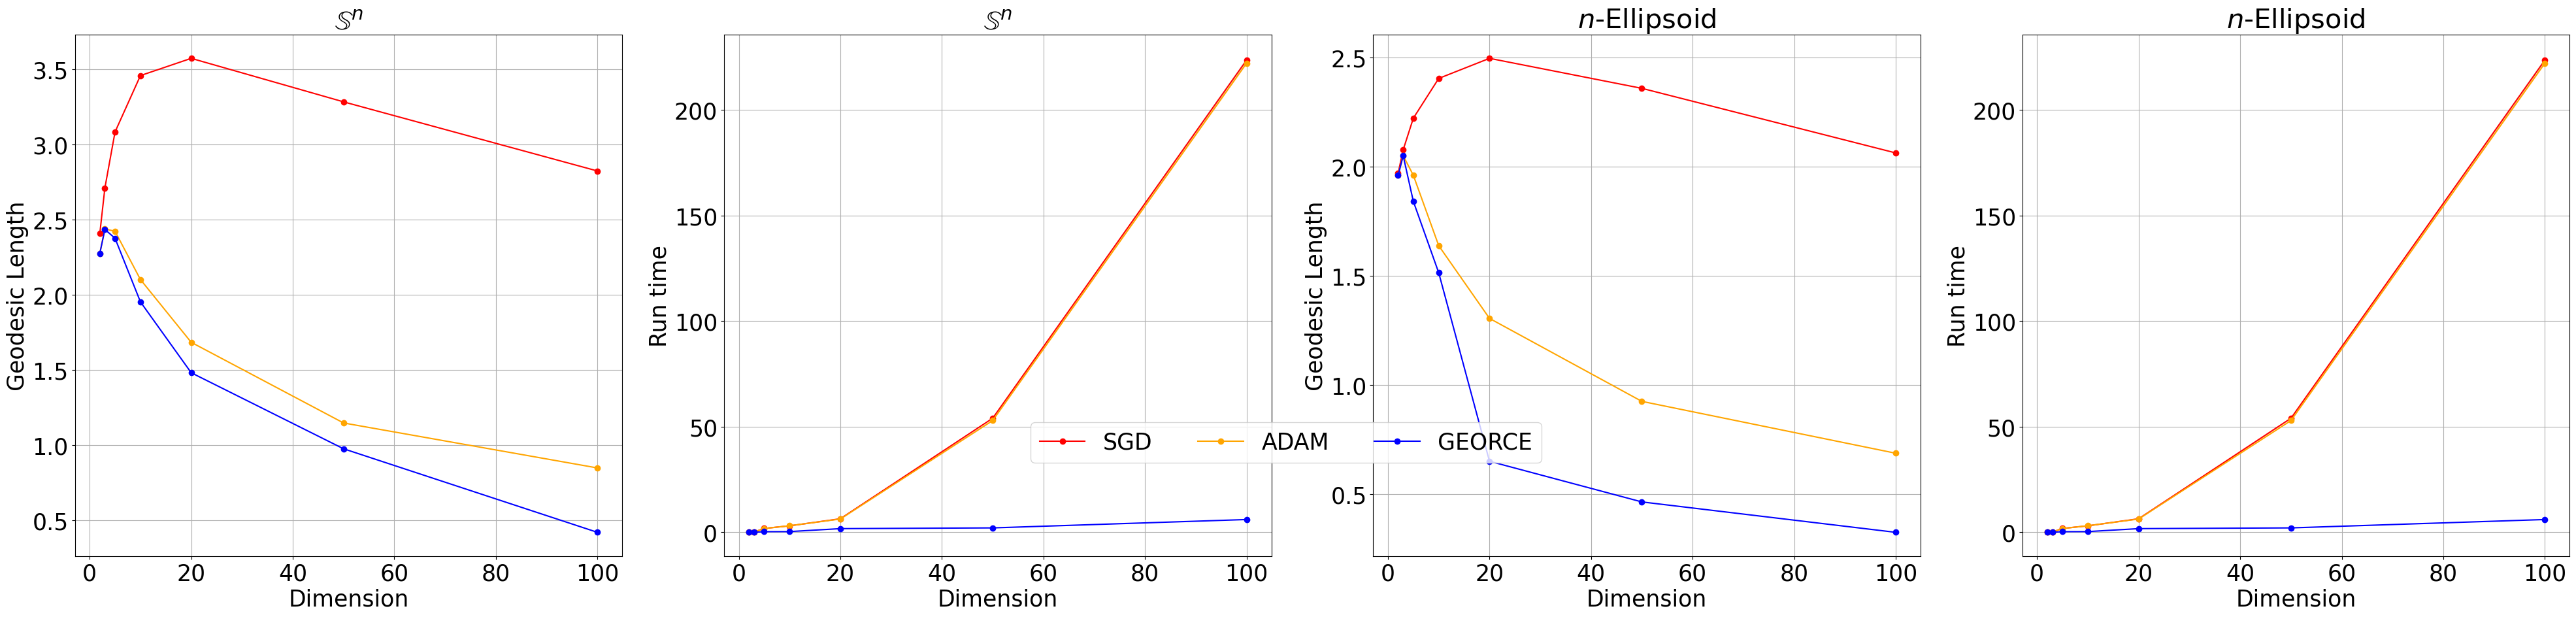

In [53]:
color = ['red', 'orange', 'blue']
methods = ['SGD', 'ADAM', 'GEORCE']
dims = [2,3,5,10,20,50,100]

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(141)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'sum_dist' in sphere_estimates[str(d)][methods[j]].keys():
            vals.append(sphere_estimates[str(d)][methods[j]]['sum-dist'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Sum of Squared Distances')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)
    
ax = fig.add_subplot(142)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)

ax = fig.add_subplot(143)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'sum_dist' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['sum_dist'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Sum of Squared Distances')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)
    
ax = fig.add_subplot(144)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j], label=methods[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.25), ncol=5)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')